In [1]:
import numpy as np
import h5py
import pandas as pd
import collections
from helpers import *
from scipy.interpolate import pchip
style_dict = styleTracks()

In [ ]:
f = h5py.File('../default_results-rej_per_eff-280.h5', 'r')
list(f.keys())
df = pd.read_hdf('../default_results-rej_per_eff-280.h5','ttbar')
df

In [11]:
class NNEvalResults:
    def __init__(self, models, epoch, sample, in_dir, out_dir, xmin=0.6, text=None):
        self.models = models
        self.epoch = epoch
        self.sample = sample
        if in_dir[-1] != '/': self.in_dir = in_dir + '/'
        else: self.in_dir = in_dir
        if out_dir[-1] != '/': self.out_dir = out_dir + '/'
        else: self.out_dir = out_dir
        self.xmin = xmin
        self.text = text
    
    def get_rej_values(self, algo):
        roc_values_dict = {}
        for model in self.models:
            df = pd.read_hdf(self.in_dir + model + "_results-rej_per_eff-" + str(self.epoch) + ".h5", self.sample)
            for jet in ['c', 'u']:
                roc_values_dict[model + '_' + jet + 'rej'] = df['{}_{}rej'.format(algo, jet)]
            if model == 'nom':
                roc_values_dict["beff"] = df["beff"]
        
        return roc_values_dict
    
    
    def configure_plot(self, jet):
        fig = plt.figure(figsize=(8, 5.5), constrained_layout=True)
        gs = gridspec.GridSpec(8, 1, figure=fig)
        ax1 = fig.add_subplot(gs[:5, 0])
        ax2 = fig.add_subplot(gs[5:, 0], sharex=ax1)
        
        ax2.set_xlabel('$b$-efficiency', fontsize=12, horizontalalignment='right', x=1.0)
        if jet == "c":
            ax1.set_ylabel('$c$-jet rejection', fontsize=12, horizontalalignment='right', y=1.0)
        if jet == "u":
            ax1.set_ylabel('light-jet rejection', fontsize=12, horizontalalignment='right', y=1.0)
        ax1.set_yscale('log')
        ax2.set_ylabel('Ratio', fontsize=12)
        ax2.grid()
        ax1.grid()
        plt.setp(ax1.get_xticklabels(), visible=False)
        
        if self.text is not None:
            ax1.text(**self.text, transform=ax1.transAxes)
        
        # Set the axes to be the same as those used in the pub note
        ax1.set_xlim(self.xmin, 1)
        ax2.set_xlim(self.xmin, 1)
        if jet == "c": ax1.set_ylim(1, 1e2)
        if jet == "u": ax1.set_ylim(1, 5e3)

        return ax1, ax2
    
    
    def plot_ROCs(self, roc_values_dict, leg_size=12):
        figname = 'PFlow_ROC'
        x = roc_values_dict["beff"]
        x2 = np.linspace(self.xmin, 1, 101)
        
        for jet in ['c', 'u']:
            figname += '_' + jet + 'rej'
            ax1, ax2 = self.configure_plot(jet)
            
            for model in self.models:
                y = roc_values_dict[model + '_' + jet + 'rej']
                ax1.plot(x, y, label=style_dict[model][1]) #color=style_dict[model][0]

                # Approximate function using x and y -> interpolate x2 values using f
                f = pchip(x, y)
                if model == 'default': #'nom'
                    f0 = f
                    ratio = np.ones(len(x2))
                else:
                    ratio = f(x2)/f0(x2)
                
                ax2.plot(x2, ratio, linewidth=1.5) #color=style_dict[model][0]
            ax1.legend(loc='best', fontsize=leg_size)
            plt.savefig(self.out_dir + figname + ".pdf", bbox_inches='tight', pad_inches=0.04)
                    

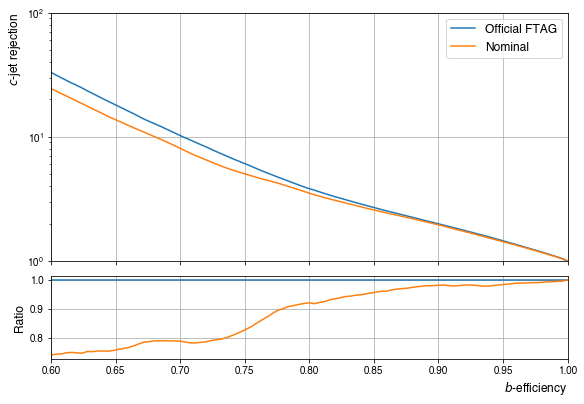

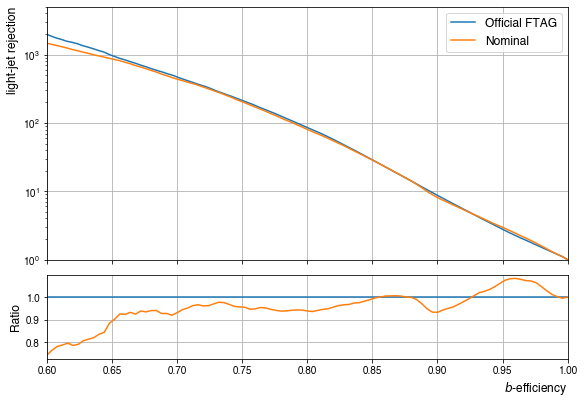

In [12]:
test = NNEvalResults(['default', 'nom'], 280, 'ttbar', '../', './plots/')
test.plot_ROCs(test.get_rej_values("dl1"))